# Advanced manual
This notebook shows some methods to make the customized target generator in more advaned ways. 

First, run the following lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from backtest_engine import BacktestEngine
from target_generator import TargetGenerator

In [2]:
# engine = BacktestEngine(API_key='ad0b46ed99911d1f77534d035a2cdb72')
engine = BacktestEngine()

T10YIE ['2000-01-01', '2004-12-31']
2000-01-01 2004-12-31
https://api.stlouisfed.org/fred/series/observations?series_id=T10YIE&observation_start=2000-01-01&observation_end=2004-12-31&api_key=ad0b46ed99911d1f77534d035a2cdb72&frequency=d&file_type=json
Index(['realtime_start', 'realtime_end', 'date', 'value'], dtype='object')
           realtime_start realtime_end value
date                                        
2003-01-02     2022-07-01   2022-07-01  1.64
2003-01-03     2022-07-01   2022-07-01  1.62
2003-01-06     2022-07-01   2022-07-01  1.63
2003-01-07     2022-07-01   2022-07-01  1.62
2003-01-08     2022-07-01   2022-07-01  1.71
...                   ...          ...   ...
2004-12-27     2022-07-01   2022-07-01  2.63
2004-12-28     2022-07-01   2022-07-01  2.62
2004-12-29     2022-07-01   2022-07-01  2.60
2004-12-30     2022-07-01   2022-07-01  2.57
2004-12-31     2022-07-01   2022-07-01  2.56

[522 rows x 3 columns]


/home/dahamkim/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dahamkim/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [6]:
# You can add tickers if you need

# macro data can be added by fred_list arg
print("available macro data : " ,engine.cache['macro'].keys())

# index data can be added by yfinance_list arg
print("available index data : " ,engine.cache['index'].keys())

available macro data :  dict_keys(['CPIAUCSL', 'PCE', 'M2', 'ICSA'])
available index data :  dict_keys(['^DJI', '^VIX', 'SPY', 'CL=F', '^GSPC', 'EEM', '^TNX', '^IXIC', 'GC=F', 'AGG', '^RUT', 'EFA', '^SP500TR'])


### CPI-based momentum/volatility rotation strategy
The following class allocates the weight according to inflation sign (CPI YoY). If CPI_YoY > 0, the weights are allocated on momentum ETFs. If CPI_YoY < 0, the weights are allocated on low-volatility ETFs.

In [11]:
class MomentumWeightGenerator(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)

    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        target_weight = {}

        momentum_zscore = self.compute_factor_zscore(universe_list=universe_list, ftype='momentum')
        invVol_zscore = self.compute_factor_zscore(universe_list=universe_list, ftype='invVol')
        """
        compute_factor_zscore method
        Inputs
            universe_list(list)
            ftype(str)
        Outputs
            pd.Series
        """        

        CPI = self.get_value(ticker='CPIAUCSL', table='macro', value='value', lag=0)
        CPI_12M = self.get_value(ticker='CPIAUCSL', table='macro', value='value', lag=12)
        CPI_chg_YoY = np.log(float(CPI)/float(CPI_12M))
        """
        get_value method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : 'openadj', 'highadj', 'lowadj', 'closeadj' for 'index' table and 'value' for 'macro' table
            lag : number of lagged data points (lag=0 gives the point-in-time latest availabe data)
            float
        """
        
        for ticker in universe_list:
            if CPI_chg_YoY > 0:
                if ticker in momentum_zscore.index and momentum_zscore[ticker] > 0:
                    target_weight[ticker] = momentum_zscore[ticker]
            else:
                if ticker in invVol_zscore.index and invVol_zscore[ticker] > 0:
                    target_weight[ticker] = invVol_zscore[ticker]
            
        target_weight = self.normalize(target_weight)

        return target_weight
    
    def custom_factor(self, ticker, ftype):
        """
        Inputs
            ticker(str) : name of ETF
            ftype(str) : name of factor
        Outputs
            float
        """
        if ftype == 'momentum':
            price = self.get_value(ticker=ticker, table='index', value='closeadj', lag=0) 
            price_12M = self.get_value(ticker=ticker, table='index', value='closeadj', lag=252) 
            momentum = np.log(price/price_12M)
            return momentum
        
        elif ftype == 'invVol':
            price_series = self.get_value_series(ticker=ticker, table='index', value='closeadj', lag=252)
            """
            get_value_series method
            Inputs
                ticker : name of ETF, index, or macro-data
                table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
                value : open, high, low, close for 'index' table and value for 'macro' table
                lag : number of lagged data points
            Outputs
                pd.Series
            """
            vol = price_series.apply(np.log).diff().std()
            return 1/vol

In [12]:
mtg = MomentumWeightGenerator(engine.cache)
custom_universe = ['XLY', 'XLP', 'XLE' ,'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
engine.run_backtest(target_generator=mtg, sdate='2010-01-01', edate='2021-01-01', custom_universe = custom_universe)

Backtest period: 2010-01-04 00:00:00 -- 2020-12-31 00:00:00
=== date:2020-12-31 00:00:00 / total_asset:3.095 / time elapsed:5.2 === date:2010-09-30 00:00:00 / total_asset:1.009 / time elapsed:1.0 === date:2011-06-30 00:00:00 / total_asset:1.186 / time elapsed:1.2 === date:2015-09-30 00:00:00 / total_asset:1.773 / time elapsed:2.9 ===
[run_backtest] is executed in 5.41 seconds


### Visualization
Now let us compare the performance of the strategy with S&P 500 index.

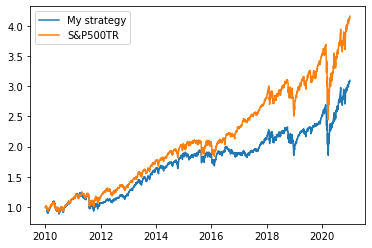

In [14]:
myasset = engine.asset_df.sum(axis=1)
benchmark = engine.cache['index']['^SP500TR']['closeadj'].loc[myasset.index]
benchmark = benchmark/benchmark.iloc[0]

plt.plot(myasset)
plt.plot(benchmark)
plt.legend(['My strategy', 'S&P500TR'])

My strategy failed to beat the benchmark. Its time to make your own!

### View cache
You can view cache data as follows.

In [15]:
print(engine.cache['macro'].keys())
engine.cache['macro']['CPIAUCSL']
# datekey : date when the value is announced
# cdate : carlendar date
# is_inferred : whether the datekey is inferred from cdate or not 

dict_keys(['ICSA', 'M2', 'CPIAUCSL', 'PCE'])


,value,is_inferred,cdate,ticker
datekey,,,,
1947-02-18,21.48,True,1947-01-01,CPIAUCSL
1947-03-21,21.62,True,1947-02-01,CPIAUCSL
1947-04-18,22.0,True,1947-03-01,CPIAUCSL
1947-05-19,22.0,True,1947-04-01,CPIAUCSL
1947-06-18,21.95,True,1947-05-01,CPIAUCSL
...,...,...,...,...
2022-02-10,281.933,False,2022-01-01,CPIAUCSL
2022-03-10,284.182,False,2022-02-01,CPIAUCSL
2022-04-12,287.708,False,2022-03-01,CPIAUCSL


In [16]:
print(engine.cache['index'].keys())
engine.cache['index']['SPY']

dict_keys(['SPY', 'VEA', 'DIA', 'XLRE', '^VIX', 'XLK', 'IVV', 'BND', 'EEM', '^IXIC', '^GSPC', 'XLI', '^RUT', 'VNQ', 'QQQ', 'XLU', 'IDEV', 'IEMG', 'XLV', 'XLY', 'XLC', 'EFA', 'UUP', 'XLE', 'XLF', 'USO', '^DJI', '^TNX', 'GC=F', '^SP500TR', 'IGF', 'GLD', 'RWO', 'XLP', 'XLB', 'CL=F'])


,openadj,highadj,lowadj,closeadj,volume,dividends,stock splits,ticker
date,,,,,,,,
1993-01-29,25.456191,25.456191,25.329544,25.438099,1003200,0.000,0.0,SPY
1993-02-01,25.456184,25.619017,25.456184,25.619017,480500,0.000,0.0,SPY
1993-02-02,25.600928,25.691390,25.546650,25.673298,201300,0.000,0.0,SPY
1993-02-03,25.709484,25.962779,25.691391,25.944687,529400,0.000,0.0,SPY
1993-02-04,26.035166,26.107537,25.745686,26.053259,531500,0.000,0.0,SPY
...,...,...,...,...,...,...,...,...
2022-06-17,365.510010,369.380005,362.170013,365.859985,111071900,1.577,0.0,SPY
2022-06-21,371.890015,376.529999,371.809998,375.070007,76811900,0.000,0.0,SPY
2022-06-22,370.619995,378.720001,370.179993,374.390015,90059400,0.000,0.0,SPY


In [17]:
engine.asset_df

,cash,XLK,XLB,XLY,XLF,XLI,XLU,XLP,XLE,XLV
2010-01-04,0.0,0.405461,0.357225,0.237315,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-05,0.0,0.404938,0.358380,0.238185,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-06,0.0,0.400408,0.364470,0.238501,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-07,0.0,0.398839,0.361635,0.240479,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-08,0.0,0.401453,0.366675,0.240400,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.0,1.314243,0.518301,0.858042,0.0,0.055538,0.0,0.112607,0.0,0.199427
2020-12-28,0.0,1.329111,0.516273,0.867825,0.0,0.055608,0.0,0.113502,0.0,0.199928
2020-12-29,0.0,1.322797,0.515042,0.868096,0.0,0.055273,0.0,0.113164,0.0,0.200876
2020-12-30,0.0,1.322084,0.522138,0.873314,0.0,0.055627,0.0,0.113046,0.0,0.200840
